# Analysis of daily minimum temperatures

In [3]:
import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import train_test_split
from prophet import Prophet

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set(rc={'figure.figsize':(15, 9)})
sns.set(font_scale=1.5) 

1. **Loaded** the `daily-min-temp-me.csv` dataset assigned it to an object named `df`. The data contains the daily minimum temperatures in Melbourne (AU) over a period of 10 years. **Printed** the first three rows of the DataFrame and **checked** its contents and column's data types. 

In [4]:
df_raw = pd.read_csv('data/daily-min-temp-me.csv')
df = df_raw.copy()

In [5]:
df.head(3)

,Date,Daily minimum temperatures
0,1/1/1981,20.7
1,1/2/1981,17.9
2,1/3/1981,18.8


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Date                        3650 non-null   object
 1   Daily minimum temperatures  3650 non-null   object
dtypes: object(2)
memory usage: 57.2+ KB


2. **Renamed** the two columns' names to `date` and `temp`, then **converted** the former to a pandas *datetime* and the latter to *float* data type *(Note: the temp variable contains a non-numeric character that I had to remove/replace before I could convert that variable to a float)*. **Checked** the columns' data type again to make sure they are in the correct format.

In [7]:
df.columns = ['date', 'temp']

In [8]:
df['date'] = pd.to_datetime(df['date'])
df['temp'] = df['temp'].str.replace('?', '')
df['temp'] = df['temp'].astype(float)

C:\Users\flbon\AppData\Local\Temp\ipykernel_14628\3041488959.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['temp'] = df['temp'].str.replace('?', '')


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3650 non-null   datetime64[ns]
 1   temp    3650 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB


3. **Plotted** a chart that shows the evolution of the daily minimum temperatures in the city of Melbourne between 1981 and 1990.

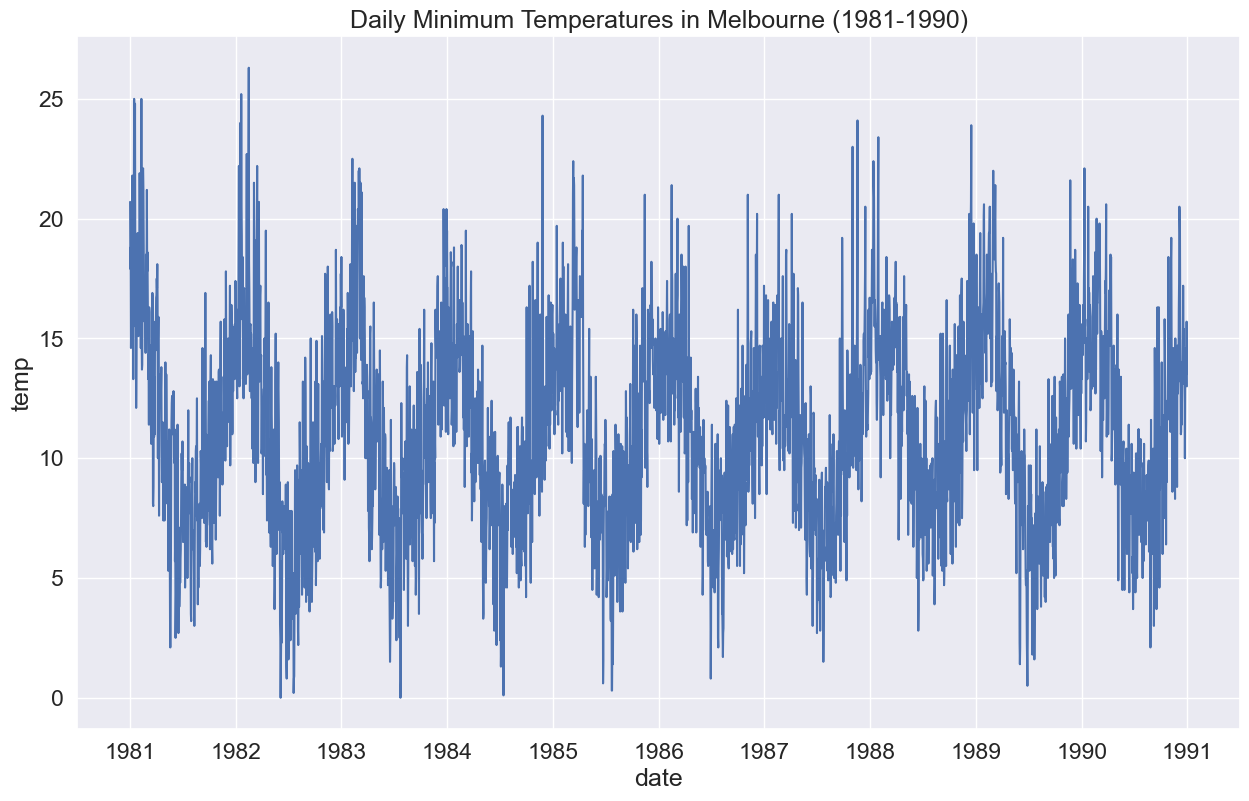

In [10]:
graph = sns.lineplot(x='date', y='temp', data=df)
graph.set_title('Daily Minimum Temperatures in Melbourne (1981-1990)')
plt.show()

4. **Created** two moving averages with a time-lag of 12 and 48 months (I called them `ma12` and `ma48` respectively) and added them as new columns to the `df` DataFrame. Then **plotted** them together with the original time series. As a fun exercise I **played** with the number of time-lags and noticed how quickly, increasing the "lookback window", the moving average line on the graphs becomes smoother. 

In [11]:
s = pd.Series(df['temp'].values, index=df['date'])

In [12]:
s

date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
              ... 
1990-12-27    14.0
1990-12-28    13.6
1990-12-29    13.5
1990-12-30    15.7
1990-12-31    13.0
Length: 3650, dtype: float64

In [13]:
ma12 = s.rolling(window=12).mean()
ma48 = s.rolling(window=48).mean()

In [14]:
df = pd.concat([df, ma12.rename('ma12')], axis=1)

In [15]:
df = pd.concat([df, ma48.rename('ma48')], axis=1)

In [16]:
df

,date,temp,ma12,ma48
0,1981-01-01,20.7,NaN,NaN
1,1981-01-02,17.9,NaN,NaN
2,1981-01-03,18.8,NaN,NaN
3,1981-01-04,14.6,NaN,NaN
4,1981-01-05,15.8,NaN,NaN
...,...,...,...,...
1990-12-27 00:00:00,NaT,NaN,13.875000,13.322917
1990-12-28 00:00:00,NaT,NaN,13.875000,13.366667
1990-12-29 00:00:00,NaT,NaN,13.841667,13.468750
1990-12-30 00:00:00,NaT,NaN,13.716667,13.533333


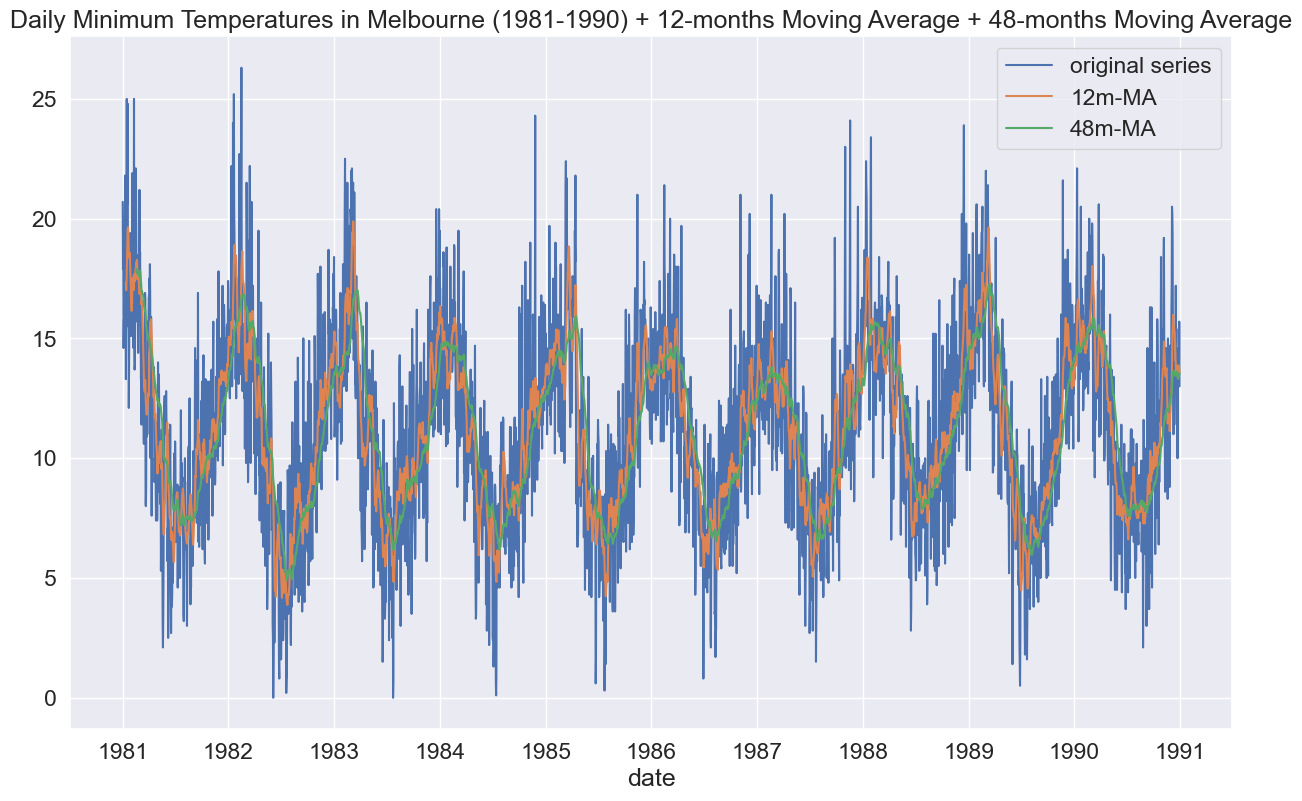

In [17]:
graph = sns.lineplot(x=s.index, y=s.values, label='original series')
graph = sns.lineplot(x=ma12.index, y=ma12.values, label='12m-MA')
graph = sns.lineplot(x=ma48.index, y=ma48.values, label='48m-MA')
graph.set_title('Daily Minimum Temperatures in Melbourne (1981-1990) + 12-months Moving Average + 48-months Moving Average')
plt.legend()
plt.show()

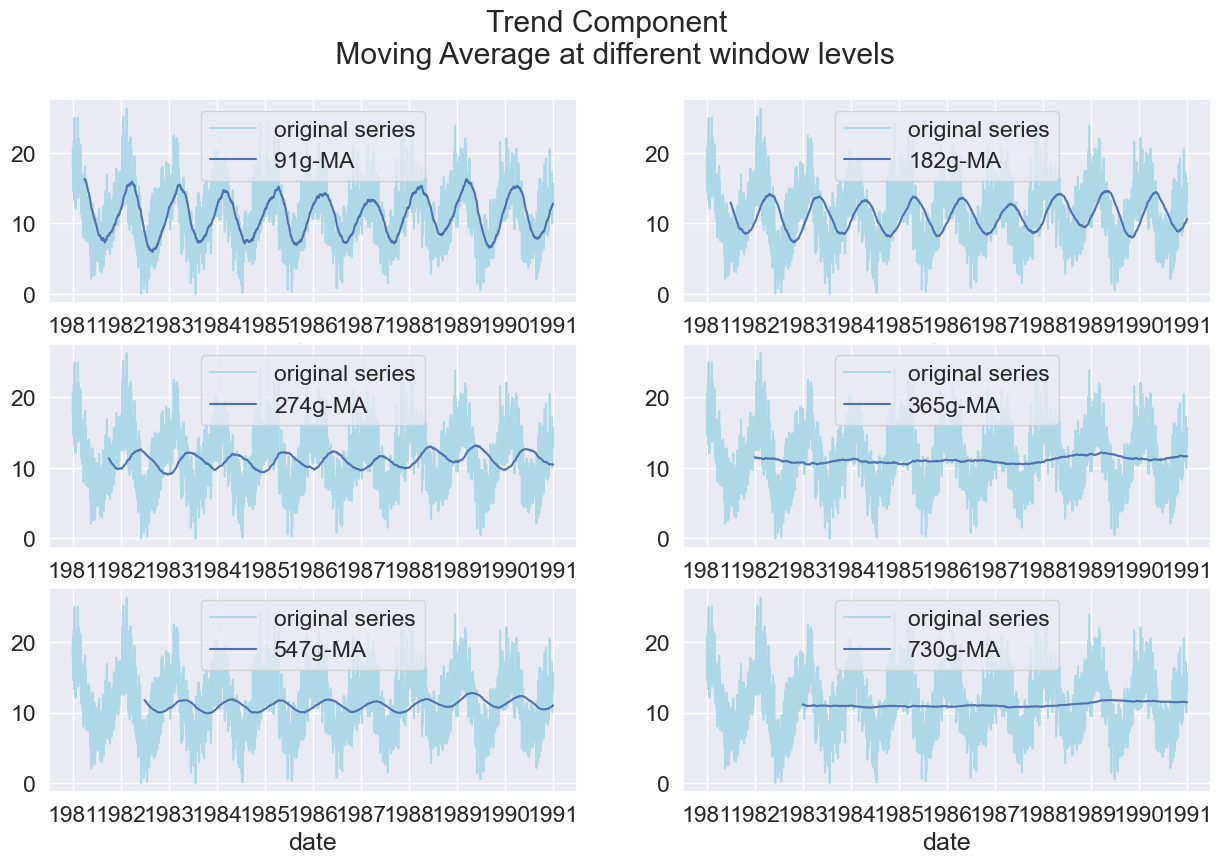

In [18]:
f, axes = plt.subplots(3, 2)

for i, ax in zip([91,182,274,365,547,730], axes.flatten()): 
    graph = sns.lineplot(x=s.index, y=s.values, label='original series', color='lightblue', ax=ax)
    ma_n = s.rolling(window=i).mean()
    graph = sns.lineplot(x=ma_n.index, y=ma_n.values, label=f'{i}g-MA', ax=ax)
plt.legend()
f.suptitle('Trend Component \n Moving Average at different window levels')
plt.show()

5. **Added** two new columns to the `df` DataFrame (called them `year` and `month`) containing the year and the month from the `date` variable. Then **plotted** the monthly trend (that is, the x-axis will have values from 1 to 12) across all available years. 

In [19]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

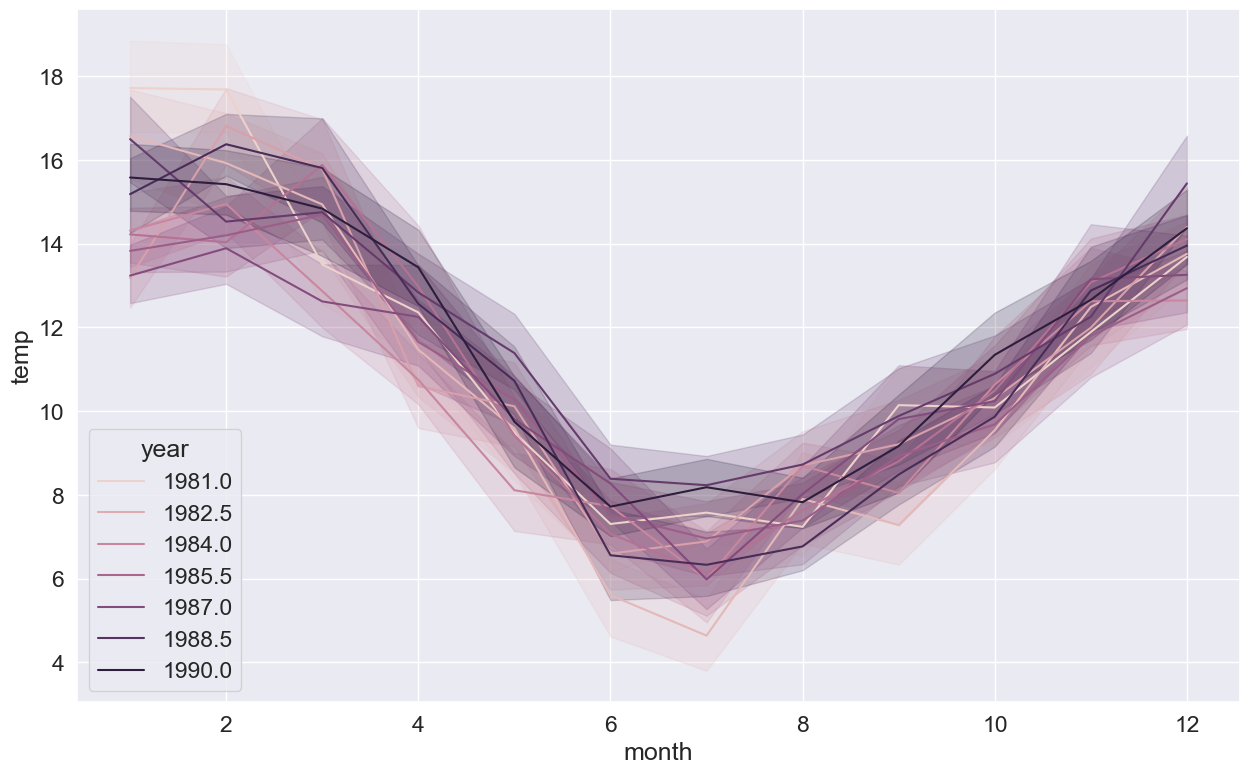

In [20]:
sns.lineplot(x='month', y='temp', hue='year', data=df)
plt.show()

The data seems to have a strong seasonality, with July being the coldest month and February the hottest.

6. Using the `STL` module from the `statsmodels` package, **decomposed** the `temp` time series into trend, seasonality and the remainder components.

In [21]:
s

date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
              ... 
1990-12-27    14.0
1990-12-28    13.6
1990-12-29    13.5
1990-12-30    15.7
1990-12-31    13.0
Length: 3650, dtype: float64

In [22]:
s.index

DatetimeIndex(['1981-01-01', '1981-01-02', '1981-01-03', '1981-01-04',
               '1981-01-05', '1981-01-06', '1981-01-07', '1981-01-08',
               '1981-01-09', '1981-01-10',
               ...
               '1990-12-22', '1990-12-23', '1990-12-24', '1990-12-25',
               '1990-12-26', '1990-12-27', '1990-12-28', '1990-12-29',
               '1990-12-30', '1990-12-31'],
              dtype='datetime64[ns]', name='date', length=3650, freq=None)

In [23]:
s.index.inferred_freq

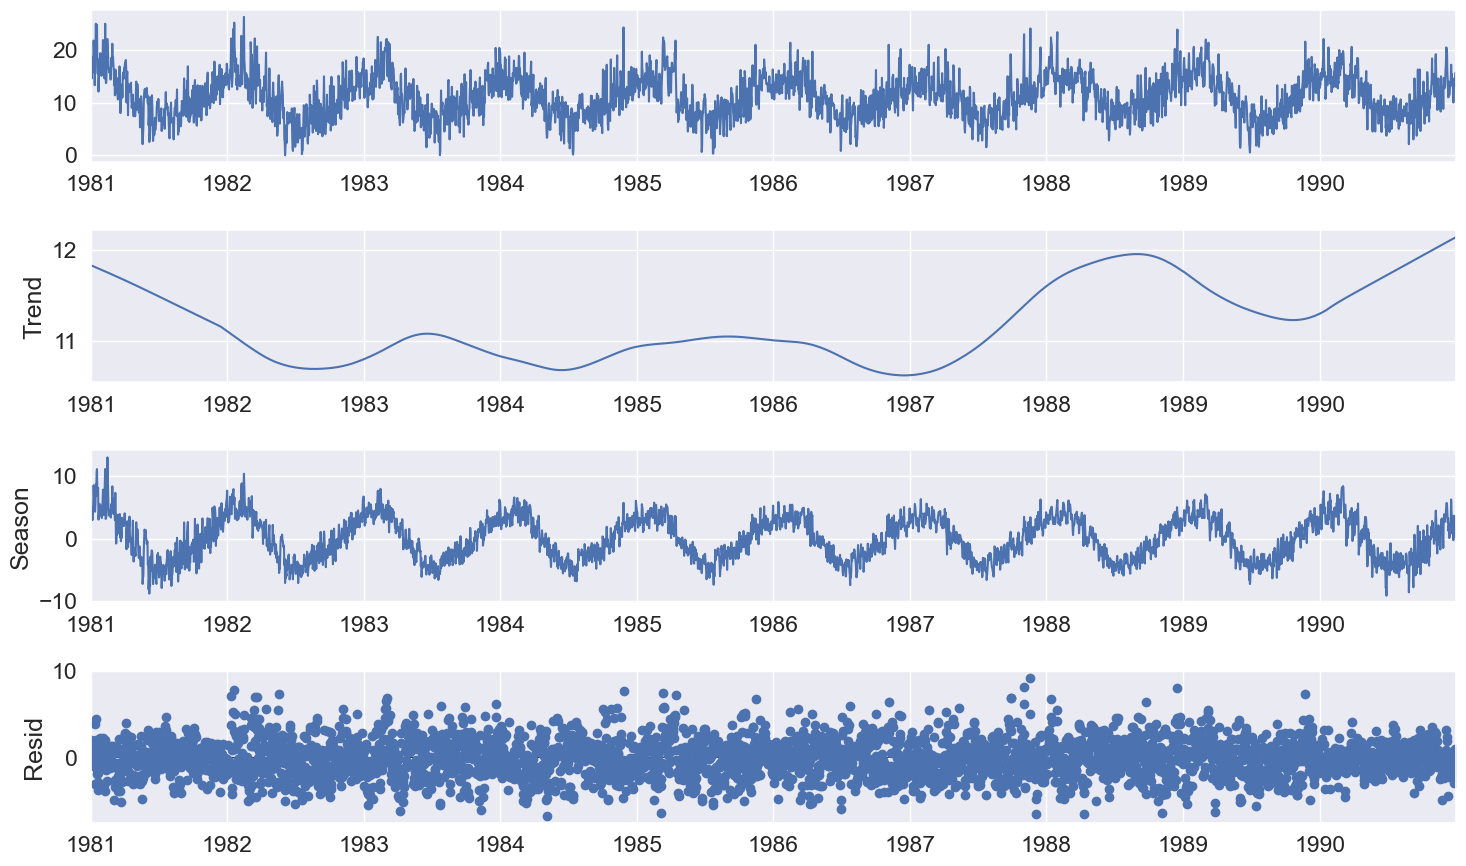

In [24]:
res = STL(s, period=365).fit()
res.plot()
plt.show()

In [25]:
detrended = s - ma12

In [26]:
detrended

date
1981-01-01         NaN
1981-01-02         NaN
1981-01-03         NaN
1981-01-04         NaN
1981-01-05         NaN
                ...   
1990-12-27    0.125000
1990-12-28   -0.275000
1990-12-29   -0.341667
1990-12-30    1.983333
1990-12-31   -0.575000
Length: 3650, dtype: float64

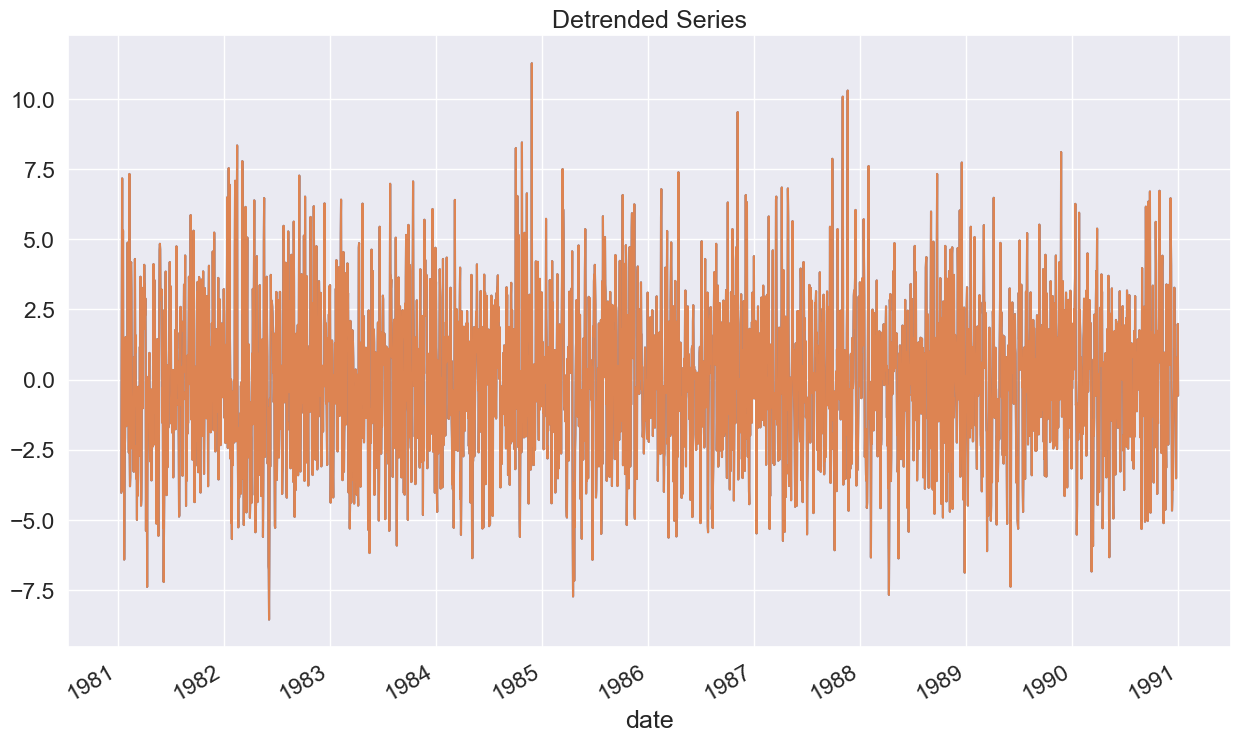

In [27]:
detrended.plot()
seas = sns.lineplot(x=detrended.index, y=detrended.values)
seas.set_title('Detrended Series')
plt.show()

In [28]:
decomp = detrended.to_frame()
decomp.columns = ['detrended']


In [29]:
decomp['date'] = pd.to_datetime(decomp.index)
decomp['year'] = decomp['date'].dt.year
decomp['month'] = decomp['date'].dt.month

In [30]:
yearly = decomp.groupby('month', as_index=False)['detrended'].mean()

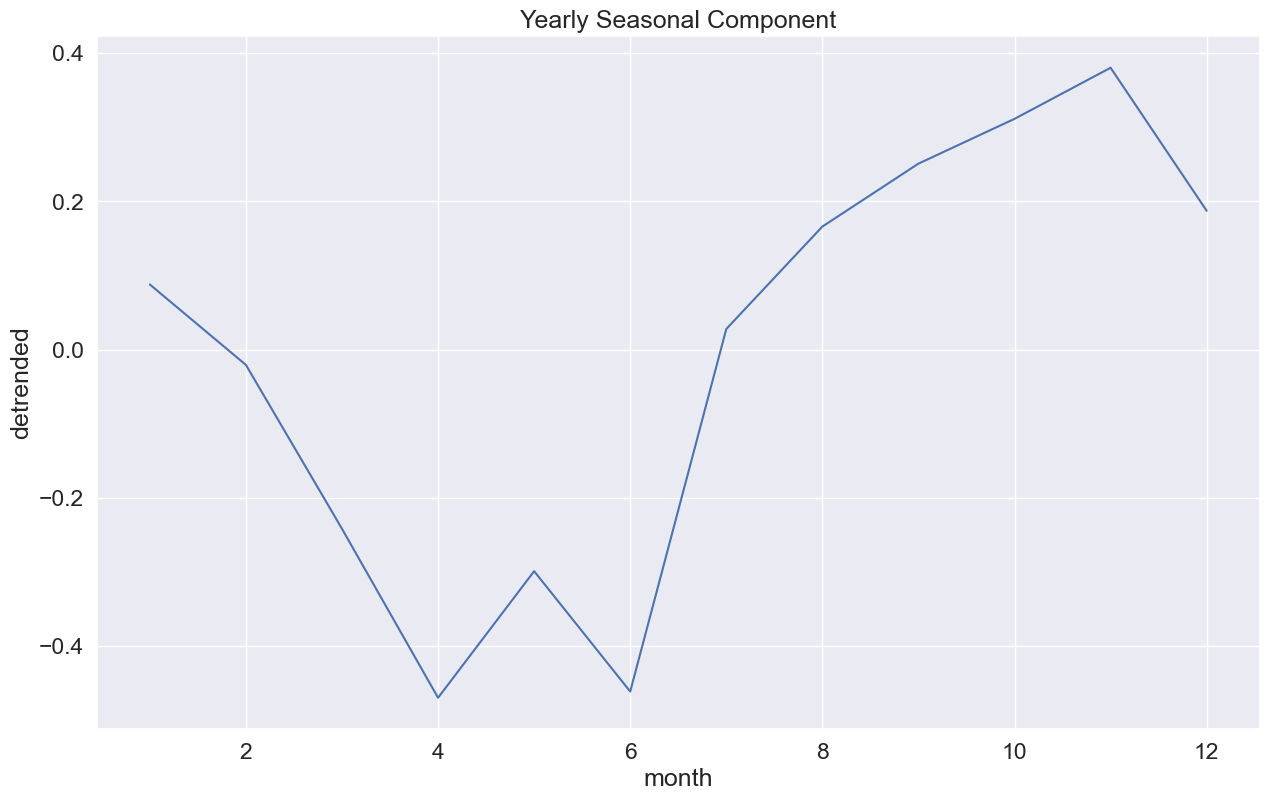

In [31]:
mseas = sns.lineplot(x='month', y='detrended', data=yearly)
mseas.set_title('Yearly Seasonal Component')
plt.show()

In [32]:
decomp = decomp.merge(yearly, left_on='month', right_on='month')

In [33]:
decomp.columns = ['detrended', 'date', 'year', 'month', 'seasonality']

In [34]:
decomp.set_index('date', inplace=True)

In [35]:
decomp = decomp.merge(ma12.to_frame(), left_index=True, right_index=True)
decomp.columns = ['detrended', 'year', 'month', 'seasonality', 'trend']

In [36]:
decomp = decomp.merge(df[['date','temp']], left_index=True, right_on='date')

In [37]:
decomp = decomp[['date', 'year', 'month', 'temp', 'trend', 'seasonality']]
decomp.head(3)

,date,year,month,temp,trend,seasonality
0,1981-01-01,1981,1,20.7,NaN,0.087988
1,1981-01-02,1981,1,17.9,NaN,0.087988
2,1981-01-03,1981,1,18.8,NaN,0.087988


In [38]:
decomp['remainder'] = decomp['temp'] - decomp['trend'] - decomp['seasonality']

In [39]:
decomp.sort_values(['date']).head(3)

,date,year,month,temp,trend,seasonality,remainder
0,1981-01-01,1981,1,20.7,NaN,0.087988,NaN
1,1981-01-02,1981,1,17.9,NaN,0.087988,NaN
2,1981-01-03,1981,1,18.8,NaN,0.087988,NaN


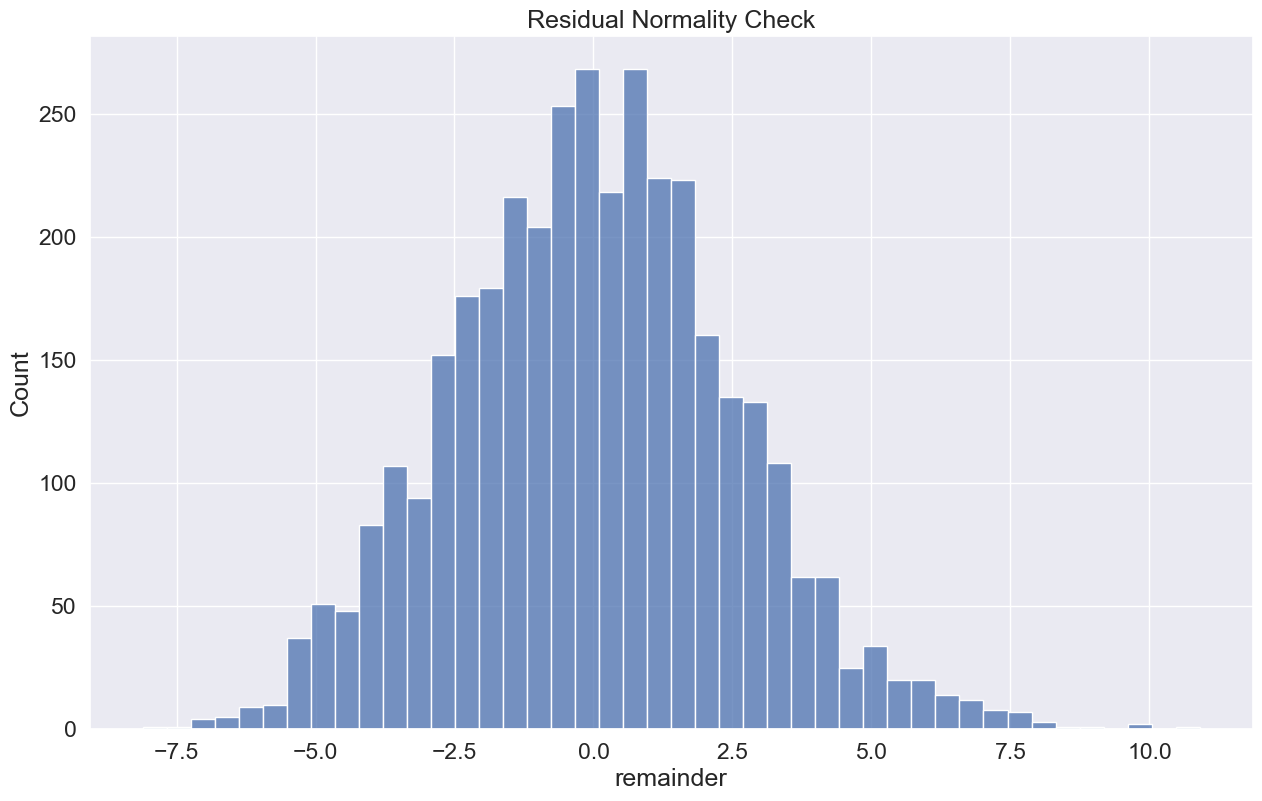

In [40]:
hist = sns.histplot(decomp.remainder)
hist.set_title('Residual Normality Check')
plt.show()

The trend stays the same the entire time, only icreasing in the latest years. This is compatible with global warming.

The seasonality clearly reflects the seaons of the year.

The distribution of the remainder is normal, which is what I was hoping to see.

7. **Split** the data into a `train` and a `test` DataFrames so that I can later train the model on all years except the last one and tested it on the full year of 1990. 

In [41]:
df_raw.columns = ['date', 'temp']

In [42]:
df_raw['temp'] = df_raw['temp'].str.replace('?', '')

C:\Users\flbon\AppData\Local\Temp\ipykernel_14628\2529316063.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_raw['temp'] = df_raw['temp'].str.replace('?', '')


In [43]:
data = df_raw.copy()
data.columns = ['ds', 'y']
data['ds'] = pd.to_datetime(data['ds'])
data.tail()

,ds,y
3645,1990-12-27,14
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7
3649,1990-12-31,13


In [44]:
train = data[data.ds<'1990-01-01']
test = data[data.ds>='1990-01-01']

8. Used the `prophet` library to **build** a forecasting model for the `train` dataset and **tested** its accuracy using both MAE and MAPE on the holdout sample (that is, on the `test` set).

In [45]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(train)

12:55:05 - cmdstanpy - INFO - Chain [1] start processing
12:55:06 - cmdstanpy - INFO - Chain [1] done processing


In [46]:
future = m.make_future_dataframe(periods=365)
future

,ds
0,1981-01-01
1,1981-01-02
2,1981-01-03
3,1981-01-04
4,1981-01-05
...,...
3645,1990-12-27
3646,1990-12-28
3647,1990-12-29
3648,1990-12-30


In [47]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3645,1990-12-27,14.935054,11.627688,18.248563
3646,1990-12-28,15.016557,11.598800,18.449462
3647,1990-12-29,15.044262,11.606638,18.437050
3648,1990-12-30,14.969148,11.229206,18.564890
3649,1990-12-31,15.286033,11.893702,19.091605


In [48]:
# interactive plotting
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(m, forecast)

In [49]:
plot_components_plotly(m, forecast)

In [50]:
pred_err = test.merge(forecast[forecast['ds']>='1990-01-01'][['ds','yhat']])
pred_err['y'] = pd.to_numeric(pred_err['y'])
pred_err['pred_error'] = pred_err.y - pred_err.yhat
pred_err

,ds,y,yhat,pred_error
0,1990-01-01,14.8,15.211951,-0.411951
1,1990-01-02,13.3,15.342886,-2.042886
2,1990-01-03,15.6,15.428684,0.171316
3,1990-01-04,14.5,15.342390,-0.842390
4,1990-01-05,14.3,15.418125,-1.118125
...,...,...,...,...
360,1990-12-27,14.0,14.935054,-0.935054
361,1990-12-28,13.6,15.016557,-1.416557
362,1990-12-29,13.5,15.044262,-1.544262
363,1990-12-30,15.7,14.969148,0.730852


In [51]:
# MAE: 
mae = np.mean(np.abs(pred_err.pred_error))
print(f'MAE: {round(mae,2)}')
# MAPE
mape = np.mean(np.abs(pred_err.pred_error/pred_err.y))*100
print(f'MAPE: {round(mape,2)}%')

MAE: 1.95
MAPE: 20.22%
